In [2]:
import time, random
import tensorwatch as tw

# create watcher object as usual
w = tw.Watcher(port=1)

weights = None
for i in range(10000):
    weights = [random.random() for _ in range(5)]

    # let watcher observe variables we have
    # this has almost no performance cost
    w.observe(weights=weights)

    time.sleep(1)

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
cand1 = pd.read_csv('delf-scored-candidates.csv', index_col=0)

print(len(cand1))
cand1.head()

In [ ]:
cand1.tail()

In [ ]:
cands = []
cands.append(pd.read_csv('delf-scored-candidates-p2.csv', index_col=0))
cands[-1].head()

In [ ]:
cands_combined = cand1.copy()
cands_combined = cands_combined.fillna(-1).sort_index()

for i, cand2 in enumerate(cands):
    cand2 = pd.concat([cand2, cands_combined[~cands_combined.index.isin(cand2.index)]])
    cand2_fn = cand2.fillna(-1).sort_index()
    cands_combined = cands_combined.where(cand2_fn < cands_combined, cand2_fn)
cands_combined.head()

In [ ]:
cands_combined.tail()

In [ ]:
print(len(cands_combined))
print(cand1.isnull().sum())
print(cands_combined.isnull().sum())
print('Negative entries:', (cand1['delf_max_score']<0).sum())

In [ ]:
cands_combined['delf_max_score'] = cands_combined[
    'delf_max_score']/cands_combined['delf_max_score'].max()
cands_combined['delf_mean_score'] = cands_combined[
    'delf_mean_score']/cands_combined['delf_mean_score'].max()
cands_combined['delf_m2_score'] = cands_combined[
    'delf_m2_score']/cands_combined['delf_m2_score'].max()

cands_combined.head()

To understand the value of `nn_w` set in the next cell, it is important to realize that most normalized delf scores have values between 0 and about 0.2. Thus, like this, the NN confidences and the delf scores are weighted roughly 50:50 unless the delf score is exceptionally high.

In [ ]:
nn_w = 0.15

score = 'delf_max_score'
predictions = pd.DataFrame(columns=['landmarks'], index=cands_combined.index)
predictions['landmarks'] = [str(int(tp))+' '+ '%.16g' % pp 
                          for tp,pp in zip(cands_combined['pred_id'].values, 
                                           ((1.-nn_w) * cands_combined[score].values 
                                            + nn_w * cands_combined['nn_conf'].values))]
predictions.head()

In [ ]:
test_info_full = pd.read_csv('test.csv', index_col=0)
print(len(test_info_full))
test_info_full.head()

In [ ]:
missing = test_info_full[test_info_full.index.isin(cands_combined.index)!=True]
missing_predictions = pd.DataFrame(index=missing.index)
missing_predictions['landmarks'] = '9633 0.0'
print(len(missing_predictions))
missing_predictions.head()

In [ ]:
completed_predictions = pd.concat([predictions, missing_predictions])
print(len(completed_predictions))

In [ ]:
sorted_predictions = pd.DataFrame(index=test_info_full.index)
sorted_predictions['landmarks' ] = completed_predictions['landmarks']
sorted_predictions.tail()

In [ ]:
sorted_predictions.to_csv('prediction_reweighted.csv')

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
from KerasVGG16Places365.vgg16_places_365 import VGG16_Places365
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd 
from PIL import Image
from cv2 import resize
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [37]:
# Placeholders for predictions
preds, confs = [], []

# Places365 Model
model = VGG16_Places365(weights='places')
topn = 5

paths = list(Path('../input/test/').glob('**/*.jpg'))
ids = list(map(lambda x: str(x).split('/')[-1].replace('.jpg', ''), paths))

# Loop through all images
for path in tqdm(paths):
    image = np.array(Image.open(path).resize((224, 224), Image.LANCZOS))
    # Predict Top N Image Classes
    image = np.expand_dims(image, 0)
    output_probs = model.predict(image)[0]
    pred = np.argsort(output_probs)[-1]
    preds.append(pred)
    confs.append(output_probs[pred])

100%|██████████| 113040/113040 [56:59<00:00, 23.94it/s] 


In [ ]:
topn_df = pd.DataFrame()
topn_df['id'] = np.array(ids)
topn_df['pred'] = np.array(preds)
topn_df['conf'] = np.array(confs)

# Read Class number, class name and class indoor/outdoor marker
class_information = pd.read_csv('./KerasVGG16Places365/categories_places365_extended.csv')
class_information.head()

# Set Class Labels
for col in ['pred']:
    topn_df[col + '_label'] = topn_df[col].map(class_information.set_index('class')['label'])
    topn_df[col + '_landmark'] = topn_df[col].map(class_information.set_index('class')['io'].replace({1:'non-landmark', 2:'landmark'}))

topn_df.to_csv('nlc_results.csv', index = False)

# Summary
topn_df.head()

In [34]:
subm = pd.read_csv('./v7_fish_nodba_train19_v18.csv.gz', index_col=0).fillna('8815 0')
subm['lid'], subm['score'] = zip(*subm['landmarks'].str.split(' ').values)
subm['score'] = subm['score'].astype(float)

topn_df = pd.read_csv('nlc_results.csv')
subm.loc[topn_df.filename, 'pred_label'] = topn_df['pred_label'].values
subm.loc[topn_df.filename, 'non_landmark'] = (topn_df['pred_landmark'].values == 'non-landmark').astype(float)
subm.loc[topn_df.filename, 'conf'] = topn_df['conf'].values

non_landmark = topn_df[topn_df['pred_landmark'] == 'non-landmark']
outdoor = topn_df[topn_df['pred_landmark'] == 'landmark']

In [203]:
subm.loc[outdoor['filename']].groupby('pred_label')['score'].agg(['count', 'mean', 'max']).sort_values('mean', ascending=False).iloc[140:]

,count,mean,max
pred_label,,,
/i/industrial_area,388,0.00074,0.00454
/f/farm,53,0.00074,0.00466
/i/inn/outdoor,390,0.00073,0.00408
/h/hunting_lodge/outdoor,230,0.00073,0.00380
/c/corn_field,105,0.00073,0.00334
/p/parking_lot,252,0.00073,0.00820
/c/creek,54,0.00073,0.00152
/j/japanese_garden,16,0.00072,0.00142
/c/campsite,790,0.00072,0.00985


In [276]:
subm[subm.pred_label == '/o/orchard'].sort_values('conf', ascending=False).head(10)

,landmarks,lid,score,pred_label,non_landmark,conf
id,,,,,,
e6c06d50f53b82ef,117093 0.000746279,117093,0.00075,/o/orchard,0.00000,0.99794
cc0f52ddbbc8cb94,107917 0.000762880,107917,0.00076,/o/orchard,0.00000,0.99486
5138058a76c36a04,111629 0.001147392,111629,0.00115,/o/orchard,0.00000,0.99097
ed8797a7c4193418,184313 0.000865100,184313,0.00087,/o/orchard,0.00000,0.98958
efbcb9e6c585b53e,131751 0.000293035,131751,0.00029,/o/orchard,0.00000,0.98890
b566806adb0bf0fb,118002 0.000521956,118002,0.00052,/o/orchard,0.00000,0.98730
d45fdb0babaaed39,181631 0.000454462,181631,0.00045,/o/orchard,0.00000,0.98477
82e3d061c3388586,93388 0.000590307,93388,0.00059,/o/orchard,0.00000,0.98177
e2d7283751f9bd96,157043 0.000496819,157043,0.00050,/o/orchard,0.00000,0.98118


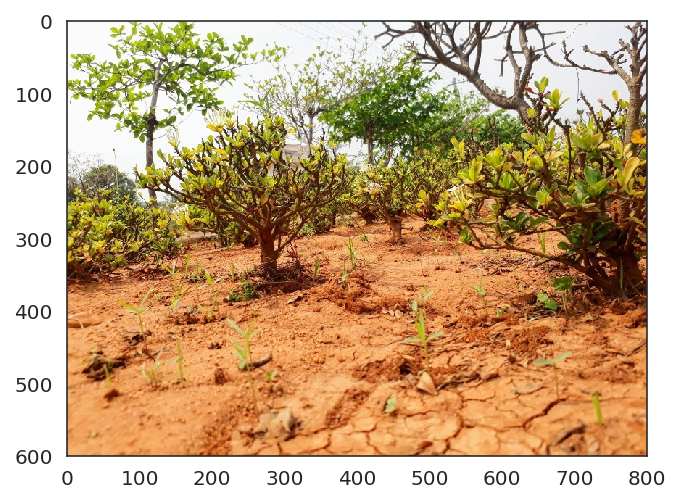

In [278]:
id_ = '5138058a76c36a04'
# id_ = subm.loc[non_landmark.filename].sort_values('conf', ascending=False).index[8]
import cv2
vis = cv2.imread(f'../input/test/{id_}.jpg')[:,:,::-1]
plt.imshow(vis)

In [133]:
conf_by_pred_label = pd.concat([
    subm.groupby('pred_label')['conf'].mean(),
    subm.groupby('pred_label')['non_landmark'].mean(),
], axis=1).sort_values('conf', ascending=False)

In [288]:
non_landmark.shape

(53713, 6)

In [291]:
subm.shape

(117703, 3)

In [302]:
threshold = 0.0

topn_df = pd.read_csv('nlc_results.csv')
# list_indoor2outdoor = [
#     '/b/burial_chamber',
#     '/m/museum/indoor',
#     '/c/church/indoor',
#     '/t/throne_room',
#     '/a/arcade',
#     '/m/museum/indoor',
#     '/s/swimming_hole',
#     '/e/elevator_shaft',
#     '/a/atrium/public',
#     '/a/archaelogical_excavation',
# ]
list_outdoor2indoor = [
    '/b/bus_station/indoor', 
    '/s/sky',  # 192160 天体
    '/f/field/wild',  # アマゾンの動物
    '/c/corn_field', 
    '/v/vegetable_garden', 
    '/p/playground', 
    '/b/beer_garden', 
    '/p/phone_booth', 
    '/v/vineyard', 
    '/d/diner/outdoor', 
    '/k/kennel/outdoor', 
    '/o/orchard', 
    '/j/junkyard', 
    '/a/army_base', 
    '/p/parking_lot', 
    '/d/driveway', 
    '/l/landing_deck', 
    '/a/airfield', 
    '/r/runway', 
    '/a/apartment_building/outdoor', 
    '/d/desert/vegetation', 
    '/c/cabin/outdoor', 
]

# topn_df.loc[topn_df[topn_df.pred_label.isin(list_indoor2outdoor)].index, 'pred_landmark'] = 'landmark'
topn_df.loc[topn_df[topn_df.pred_label.isin(list_outdoor2indoor)].index, 'pred_landmark'] = 'non-landmark'

subm = pd.read_csv('./v7_fish_nodba_train19_v18.csv.gz', index_col=0).fillna('8815 0')
subm['lid'], subm['score'] = zip(*subm['landmarks'].str.split(' ').values)

nl_ids = topn_df[(topn_df['pred_landmark'] == 'non-landmark') & (topn_df['conf'] > threshold)]['id']

topn_df['factor'] = 1.0 - topn_df['conf']
non_landmark = topn_df[topn_df['pred_landmark'] == 'non-landmark']
subm.loc[non_landmark['id'], 'score'] =  subm.loc[non_landmark['id'], 'score'].values.astype(float) * non_landmark['factor'].values

subm['score'] = subm['score'].astype(str)
subm['landmarks'] = subm.apply(lambda x: ' '.join([x['lid'], x['score']]), axis=1)

ban_list = [28641, 39209, 62065, 62074, 171772, 23118, 67929]
for suspicious_lid in ban_list:
    subm[subm['landmarks'].str.contains(f'{suspicious_lid} ')] = f'{suspicious_lid} 0'

subm[['landmarks']].to_csv('./exclude_and_apply_nlc_o2i_adaptive_to_v18.csv.gz', compression='gzip')

In [303]:
!kaggle c submit -c landmark-recognition-2019 -f './exclude_and_apply_nlc_o2i_adaptive_to_v18.csv.gz' -m ''

100%|███████████████████████████████████████| 2.26M/2.26M [00:09<00:00, 242kB/s]
Successfully submitted to Google Landmark Recognition 2019

In [2]:
# !git clone https://github.com/CSAILVision/places365.git

Cloning into 'places365'...
remote: Enumerating objects: 251, done.
remote: Total 251 (delta 0), reused 0 (delta 0), pack-reused 251
Receiving objects: 100% (251/251), 1.36 MiB | 2.79 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [1]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd 
from PIL import Image
from cv2 import resize
import matplotlib.pyplot as plt

# th architecture to use
arch = 'resnet50'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model = model.eval().cuda()

# load the image transformer
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the class label
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

preds, confs = [], []

paths = list(Path('../input/test/').glob('**/*.jpg'))
ids = list(map(lambda x: str(x).split('/')[-1].replace('.jpg', ''), paths))

# Loop through all images
for path in tqdm(paths):
    img = Image.open(path)
    input_img = V(centre_crop(img).unsqueeze(0)).cuda()
    
    with torch.no_grad():
        logit = model(input_img)
        output_probs = F.softmax(logit, 1).cpu().squeeze()
        pred = output_probs.argmax()

        preds.append(pred)
        confs.append(output_probs[pred])


topn_df = pd.DataFrame()
topn_df['id'] = np.array(ids)
topn_df['pred'] = np.array(preds)
topn_df['conf'] = np.array(confs)

# Read Class number, class name and class indoor/outdoor marker
class_information = pd.read_csv('./KerasVGG16Places365/categories_places365_extended.csv')

# Set Class Labels
for col in ['pred']:
    topn_df[col + '_label'] = topn_df[col].map(class_information.set_index('class')['label'])
    topn_df[col + '_landmark'] = topn_df[col].map(class_information.set_index('class')['io'].replace({1:'non-landmark', 2:'landmark'}))

topn_df.to_csv('nlc_results_resnet50.csv', index = False)

# Summary
topn_df.head()

100%|██████████| 113040/113040 [1:39:21<00:00, 18.96it/s] 


,id,pred,conf,pred_label,pred_landmark
0,fc9ed2682f5031e9,353,0.808404,/w/water_park,landmark
1,0724ed7fbfe67000,324,0.632988,/s/swimming_hole,non-landmark
2,06a0dd0becc09d9e,114,0.351442,/d/delicatessen,non-landmark
3,0f01581190f775d5,156,0.777259,/g/garage/indoor,non-landmark
4,8505a16f3788efff,204,0.211111,/l/lagoon,landmark
